# Example Model Servers with Seldon

## Prerequistes
You will need
 - [Git clone of Seldon Core](https://github.com/SeldonIO/seldon-core)
 - A running Kubernetes cluster with kubectl authenticated
 - [seldon-core Python package](https://pypi.org/project/seldon-core/) (```pip install seldon-core>=0.2.6.1```)
 - [Helm client](https://helm.sh/)

### Creating a Kubernetes Cluster

Follow the [Kubernetes documentation to create a cluster](https://kubernetes.io/docs/setup/).

Once created ensure ```kubectl``` is authenticated against the running cluster.

## Setup

In [ ]:
!kubectl create namespace seldon

In [ ]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

In [ ]:
!kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default

## Install Helm

In [ ]:
!kubectl -n kube-system create sa tiller
!kubectl create clusterrolebinding tiller --clusterrole cluster-admin --serviceaccount=kube-system:tiller
!helm init --service-account tiller

In [ ]:
!kubectl rollout status deploy/tiller-deploy -n kube-system

## Start seldon-core

In [ ]:
!helm install ../helm-charts/seldon-core-operator --name seldon-core  --set image.pullPolicy=Never --set usageMetrics.enabled=true --namespace seldon-system

In [ ]:
!kubectl rollout status statefulset.apps/seldon-operator-controller-manager -n seldon-system

## Setup Ingress
Please note: There are reported gRPC issues with ambassador (see https://github.com/SeldonIO/seldon-core/issues/473).

In [ ]:
!helm install stable/ambassador --name ambassador --set crds.keep=false

In [ ]:
!kubectl rollout status deployment.apps/ambassador

### Port Forward to Ambassador

```
kubectl port-forward $(kubectl get pods -n seldon -l app.kubernetes.io/name=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8003:8080
```

## Income Prediction Model

In [ ]:
!pygmentize resources/income_explainer.yaml

In [ ]:
!kubectl apply -f resources/income_explainer.yaml

In [ ]:
!kubectl rollout status deploy/income-default-4903e3c

In [ ]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="income",namespace="seldon")

In [ ]:
data = np.array([[39, 7, 1, 1, 1, 1, 4, 1, 2174, 0, 40, 9]])
r = sc.predict(gateway="ambassador",transport="rest",data=data)
print(r)

In [ ]:
data = np.array([[39, 7, 1, 1, 1, 1, 4, 1, 2174, 0, 40, 9]])
explanation = sc.explain(deployment_name="income",gateway="ambassador",transport="rest",data=data)
print(explanation["names"])

In [ ]:
!kubectl delete -f resources/income_explainer.yaml

## Movie Sentiment Model



In [ ]:
!pygmentize resources/moviesentiment_explainer.yaml

In [ ]:
!kubectl apply -f resources/moviesentiment_explainer.yaml

In [ ]:
!kubectl rollout status deploy/movie-default-4903e3c

In [ ]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="movie",namespace="seldon")

In [ ]:
data = np.array(['this film has great actors'])
r = sc.predict(gateway="ambassador",transport="rest",data=data,payload_type='ndarray')
print(r)

In [ ]:
data = np.array(['this film has great actors'])
explanation = sc.explain(deployment_name="movie",gateway="ambassador",transport="rest",data=data,payload_type='ndarray')
print(explanation)

In [ ]:
!kubectl delete -f resources/moviesentiment_explainer.yaml

## Imagenet Model



In [ ]:
!pygmentize resources/imagenet_explainer.yaml

In [ ]:
!kubectl apply -f resources/imagenet_explainer.yaml

In [ ]:
!kubectl rollout status deploy/image-default-c79fbd1

In [17]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
import alibi
from alibi.datasets import fetch_imagenet
import numpy as np

def get_image_data():
    category = 'Persian cat'
    image_shape = (299, 299, 3)
    data, _ = fetch_imagenet(category, nb_images=30, target_size=image_shape[:2], seed=2,
                                  return_X_y=True)
    return data

data = get_image_data()
images = preprocess_input(data)


In [18]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="image",namespace="seldon",grpc_max_send_message_length= 27 * 1024 * 1024,grpc_max_receive_message_length= 27 * 1024 * 1024)

In [43]:
import tensorflow as tf
#req = np.expand_dims(images[0], axis=0)
req = images[0:2]
r = sc.predict(gateway="ambassador",transport="grpc",data=req,payload_type='tensor')
preds = tf.make_ndarray(r.response.data.tftensor)
#preds = np.array(r.response.data.tensor.values)
#preds = preds.reshape(r.response.data.tensor.shape)

decode_predictions(preds, top=2)
#plt.title(label[0])
#plt.imshow(data[0])

[[('n02123394', 'Persian_cat', 0.9093481),
  ('n03207941', 'dishwasher', 0.0027691843)],
 [('n03026506', 'Christmas_stocking', 0.5888809),
  ('n02123394', 'Persian_cat', 0.35741013)]]

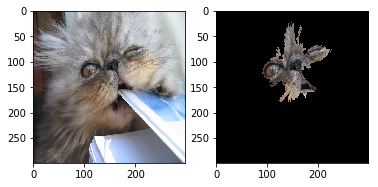

In [45]:
req = np.expand_dims(images[0], axis=0)
explanation = sc.explain(deployment_name="image",gateway="ambassador",transport="rest",data=req)
exp_arr = np.array(explanation['anchor'])

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(data[0])
axarr[1].imshow(explanation['anchor'])
plt.show()


In [ ]:
!kubectl delete -f resources/moviesentiment_explainer.yaml